In [1]:
import glob
import os
from random import *
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

import torchio as tio

from monai.config import print_config
from monai.data import ArrayDataset, CacheDataset, DataLoader, Dataset, partition_dataset, PatchDataset, GridPatchDataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, MaskedDiceLoss, GeneralizedDiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    AddChannel,
    AddChanneld,
    Compose,
    LoadImage,
    LoadNifti,
    LoadNiftid,
    ToTensor,
    ToTensord,
    RandSpatialCropSamplesd,
)
from monai.utils import first, set_determinism

print_config()
print('TorchIO version:', tio.__version__)

MONAI version: 0.4.0
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.0.1
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.55.2
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

TorchIO version: 0.18.6


In [2]:
os.environ["MONAI_DATA_DIRECTORY"] = "E:/DL_tools/torch_ex/data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

E:/DL_tools/torch_ex/data


In [3]:
data_dir = os.path.join(root_dir, "nifti_data")
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "mask", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [4]:
### image augmentation transform with monai and torchio API

#train_transforms_monai = [
#        LoadNiftid(keys=["image", "label"]),
#        AddChanneld(keys=["image", "label"]),
#        ToTensord(keys=["image", "label"]),
#]

In [5]:
train_transforms_monai = Compose([LoadImage(image_only = True), AddChannel(), ToTensor()])
val_transforms_monai = Compose([LoadImage(image_only = True), AddChannel(), ToTensor()])

In [6]:
train_data, val_data, test_data = partition_dataset(data_dicts, ratios = [0.6, 0.2, 0.2], shuffle = True)

In [7]:
train_imgs = (list(m["image"] for m in train_data))
train_segs = (list(m["label"] for m in train_data))
val_imgs = (list(m["image"] for m in val_data))
val_segs = (list(m["label"] for m in val_data))
test_imgs = (list(m["image"] for m in test_data))
test_segs = (list(m["label"] for m in test_data))

In [8]:
train_ds = ArrayDataset(train_imgs, train_transforms_monai, train_segs, train_transforms_monai)
val_ds = ArrayDataset(val_imgs, val_transforms_monai, val_segs, val_transforms_monai)
test_ds = ArrayDataset(test_imgs, val_transforms_monai, test_segs, val_transforms_monai)

In [9]:
train_ds_patched = GridPatchDataset(dataset = train_ds, patch_size = (80, 80, 16))
val_ds_patched = GridPatchDataset(dataset = val_ds, patch_size = (80, 80, 16))
test_ds_patched = GridPatchDataset(dataset = test_ds, patch_size = (80, 80, 16))

In [10]:
train_loader = torch.utils.data.DataLoader(train_ds_patched, batch_size=72, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_ds_patched, batch_size=64, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds_patched, batch_size=32, shuffle=False, num_workers=0)

In [11]:
#im, seg = first(train_loader)
im, seg = next(iter(train_loader))
print(im.shape, seg.shape)

torch.Size([72, 1, 80, 80, 16]) torch.Size([72, 1, 80, 80, 16])


In [12]:
### custom defined visualization function
def plot_image_and_mask(imgset, maskset):
    index1 = randint(0,len(imgset[0,0,0,0,:])-1)
    print(index1)
    im_batch = imgset[:,:,:,:,index1]
    seg_batch = maskset[:,:,:,:,index1]
    im_batch_grid = torchvision.utils.make_grid(im_batch, nrow=8, normalize = True)
    seg_batch_grid = torchvision.utils.make_grid(seg_batch, nrow=8)
    np_im_batch_grid = im_batch_grid.numpy()
    np_seg_batch_grid = seg_batch_grid.numpy()
    fig, axs = plt.subplots(1,2, figsize=(20,200))
    axs[0].title.set_text("Patched MRI images") # set title
    axs[0].imshow(np.transpose(np_im_batch_grid, (1, 2, 0))) # show MRI 
    axs[1].title.set_text("Corresponding masks") # plot title on the mask 
    axs[1].imshow(np.transpose(np_seg_batch_grid, (1, 2, 0))) # Show corresponding mask
    fig.tight_layout()

1


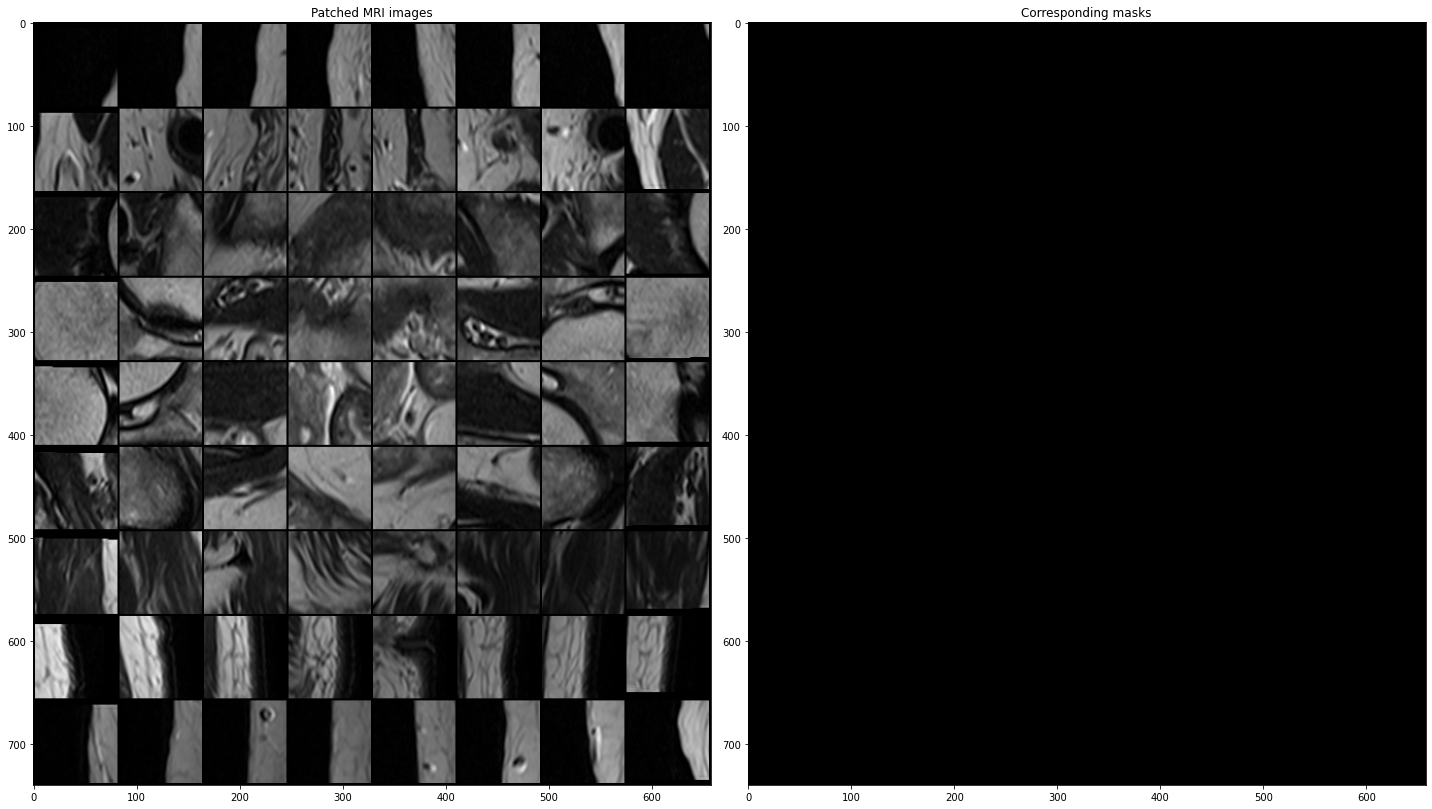

In [13]:
plot_image_and_mask(im, seg)

torch.Size([64, 1, 80, 80, 16]) torch.Size([64, 1, 80, 80, 16])
4


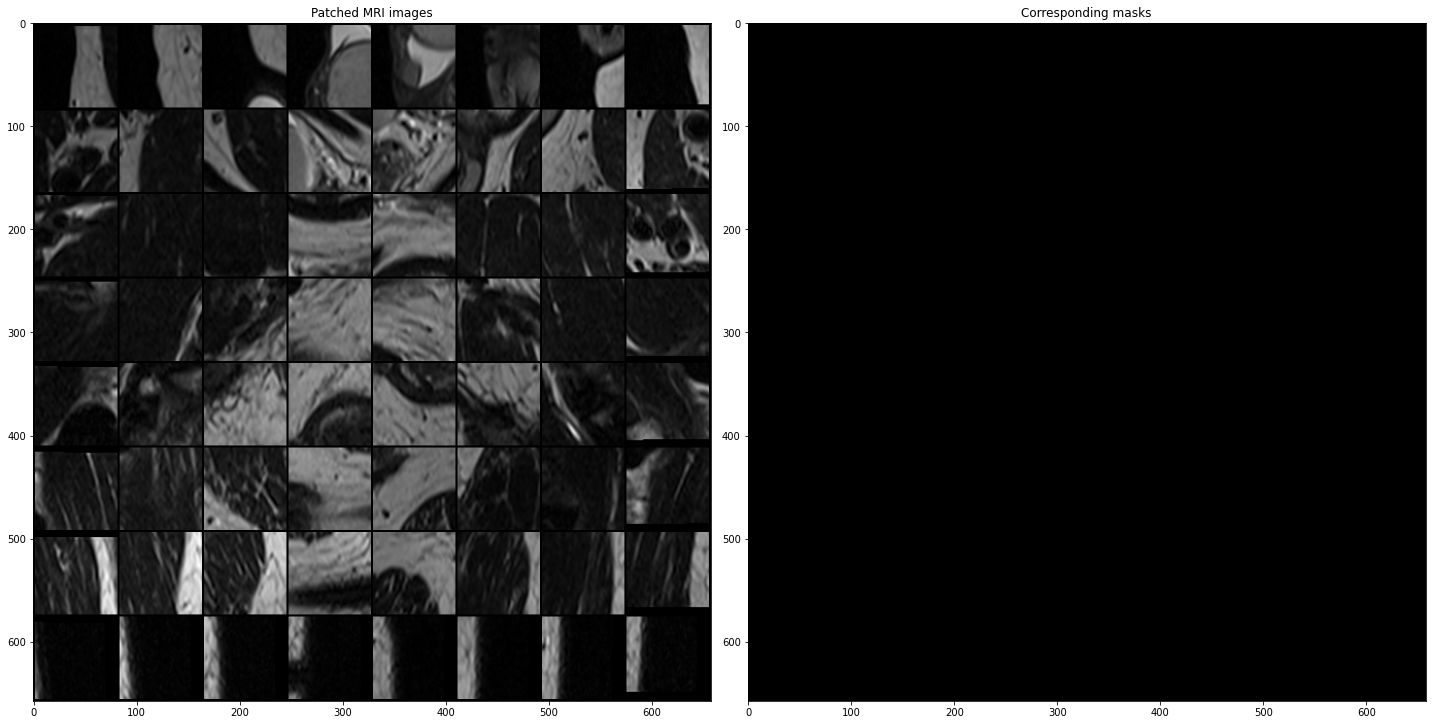

In [14]:
im_val, segs_val = next(iter(val_loader))
print(im_val.shape, segs_val.shape)
plot_image_and_mask(im_val, segs_val)

In [15]:
# standard PyTorch program style: create UNet
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
    dropout=0.4
)

# model summary
from torchsummaryX import summary
summary(model, torch.zeros((64, 1, 80, 80, 16), device="cpu"))

device = torch.device("cuda:0")
model.to(device)

## loss function and optimizer: DiceLoss and Adam optimizer
loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

                                                           Kernel Shape  \
Layer                                                                     
0_model.0.Conv3d_residual                              [1, 16, 3, 3, 3]   
1_model.0.conv.unit0.Conv3d_conv                       [1, 16, 3, 3, 3]   
2_model.0.conv.unit0.adn.BatchNorm3d_N                             [16]   
3_model.0.conv.unit0.adn.Dropout_D                                    -   
4_model.0.conv.unit0.adn.PReLU_A                                    [1]   
5_model.0.conv.unit1.Conv3d_conv                      [16, 16, 3, 3, 3]   
6_model.0.conv.unit1.adn.BatchNorm3d_N                             [16]   
7_model.0.conv.unit1.adn.Dropout_D                                    -   
8_model.0.conv.unit1.adn.PReLU_A                                    [1]   
9_model.0.conv.unit2.Conv3d_conv                      [16, 16, 3, 3, 3]   
10_model.0.conv.unit2.adn.BatchNorm3d_N                            [16]   
11_model.0.conv.unit2.adn

In [16]:
## train start
import math
epoch_num = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data[0].to(device),
            batch_data[1].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{math.ceil(len(train_ds)*64*2 // train_loader.batch_size)}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                roi_size = (80, 80, 16)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=True,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
1/42, train_loss: 0.3818
2/42, train_loss: 0.3749
3/42, train_loss: 0.3823
4/42, train_loss: 0.3406
5/42, train_loss: 0.3475
6/42, train_loss: 0.3952
7/42, train_loss: 0.3431
8/42, train_loss: 0.3509
9/42, train_loss: 0.3394
10/42, train_loss: 0.3375
11/42, train_loss: 0.3280
12/42, train_loss: 0.3266
13/42, train_loss: 0.3428
14/42, train_loss: 0.3569
15/42, train_loss: 0.3226
16/42, train_loss: 0.3247
17/42, train_loss: 0.3384
18/42, train_loss: 0.2991
19/42, train_loss: 0.3013
20/42, train_loss: 0.2887
21/42, train_loss: 0.3359
22/42, train_loss: 0.2979
23/42, train_loss: 0.2826
24/42, train_loss: 0.2551
25/42, train_loss: 0.2710
26/42, train_loss: 0.2282
27/42, train_loss: 0.2616
28/42, train_loss: 0.2456
29/42, train_loss: 0.2404
30/42, train_loss: 0.2437
31/42, train_loss: 0.2704
32/42, train_loss: 0.2453
33/42, train_loss: 0.2513
34/42, train_loss: 0.2579
35/42, train_loss: 0.2533
36/42, train_loss: 0.2457
37/42, train_loss: 0.2498
38/42, train_loss: 0.236

TypeError: object of type 'NoneType' has no len()

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

In [18]:
train_loader.batch_size

72